In [5]:
# --- Import Necessary Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import os # Import the os module for path manipulation

# --- ULTIMATE NLTK DATA PATH FIX AND GUARANTEED DOWNLOAD ---
# Define a dedicated directory for NLTK data.
project_root = r'C:\Users\Shib\Documents\Financial-News-Sentiment-Project'
nltk_data_dir = os.path.join(project_root, 'nltk_data')

# Create the directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)
print(f"Ensuring NLTK data directory exists at: {nltk_data_dir}")

# Add this directory to NLTK's search path if it's not already there
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)
    print(f"Added '{nltk_data_dir}' to NLTK data paths.")
else:
    print(f"Path '{nltk_data_dir}' already in NLTK data paths.")

# Now, explicitly download ALL necessary NLTK packages to this controlled location.

print("\n--- Downloading/Verifying NLTK 'punkt' tokenizer ---")
try:
    if not os.path.exists(os.path.join(nltk_data_dir, 'tokenizers', 'punkt')):
        print("NLTK 'punkt' tokenizer data not found. Attempting download...")
        nltk.download('punkt', download_dir=nltk_data_dir)
        print("NLTK 'punkt' tokenizer download completed or re-verified.")
    else:
        print("NLTK 'punkt' tokenizer already exists at the specified path.")
except Exception as e:
    print(f"Failed to download/verify 'punkt' tokenizer: {e}")

# --- ADD THIS NEW BLOCK FOR 'punkt_tab' ---
print("\n--- Downloading/Verifying NLTK 'punkt_tab' tokenizer ---")
try:
    # 'punkt_tab' is often found under 'tokenizers/punkt_tab/english'
    if not os.path.exists(os.path.join(nltk_data_dir, 'tokenizers', 'punkt_tab', 'english')):
        print("NLTK 'punkt_tab' tokenizer data not found. Attempting download...")
        nltk.download('punkt_tab', download_dir=nltk_data_dir)
        print("NLTK 'punkt_tab' tokenizer download completed or re-verified.")
    else:
        print("NLTK 'punkt_tab' tokenizer already exists at the specified path.")
except Exception as e:
    print(f"Failed to download/verify 'punkt_tab' tokenizer: {e}")
# --- END NEW BLOCK ---

print("\n--- Downloading/Verifying NLTK 'stopwords' corpus ---")
try:
    if not os.path.exists(os.path.join(nltk_data_dir, 'corpora', 'stopwords')):
        print("NLTK 'stopwords' corpus data not found. Attempting download...")
        nltk.download('stopwords', download_dir=nltk_data_dir)
        print("NLTK 'stopwords' corpus download completed or re-verified.")
    else:
        print("NLTK 'stopwords' corpus already exists at the specified path.")
except Exception as e:
    print(f"Failed to download/verify 'stopwords' corpus: {e}")


# Set a consistent visual style for plots
sns.set_style("whitegrid")

# --- Rest of your existing code follows directly from here ---
# (Your file_path, data loading, cleaning, descriptive stats, etc. remain unchanged)
# file_path = r'C:\Users\Shib\Documents\Financial-News-Sentiment-Project\data\raw_analyst_ratings.csv\raw_analyst_ratings.csv'
# ... (your existing code for data loading, cleaning, etc.)

Ensuring NLTK data directory exists at: C:\Users\Shib\Documents\Financial-News-Sentiment-Project\nltk_data
Added 'C:\Users\Shib\Documents\Financial-News-Sentiment-Project\nltk_data' to NLTK data paths.

--- Downloading/Verifying NLTK 'punkt' tokenizer ---
NLTK 'punkt' tokenizer already exists at the specified path.

--- Downloading/Verifying NLTK 'punkt_tab' tokenizer ---
NLTK 'punkt_tab' tokenizer already exists at the specified path.

--- Downloading/Verifying NLTK 'stopwords' corpus ---
NLTK 'stopwords' corpus already exists at the specified path.


In [6]:
file_path = r'C:\Users\Shib\Documents\Financial-News-Sentiment-Project\data\raw_analyst_ratings.csv\raw_analyst_ratings.csv'

In [7]:
# --- Step 1: Load the Financial News Data ---
try:
    news_df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print("\n--- First 5 rows of the DataFrame ---")
    print(news_df.head())
    print("\n--- DataFrame Information ---")
    news_df.info()
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path.")
    exit() # Exit the script if the file isn't found, as we can't proceed
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit() # Exit on other loading errors

Dataset loaded successfully!

--- First 5 rows of the DataFrame ---
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A 

In [8]:
# --- Step 2: Initial Data Cleaning and Type Conversion ---
print("\n--- Data Cleaning and Type Conversion ---")
# Convert 'date' column to datetime objects
# The project specifies UTC-4. We'll convert to UTC first, then localize.
# A common way to handle various date formats is to let pandas infer,
# but if it fails, you might need to specify the format.
# Example: format='%Y-%m-%d %H:%M:%S%z' if the format is '2023-10-26 10:00:00-04:00'

# First, attempt to parse the 'date' column as datetime, inferring formats
# errors='coerce' will turn unparseable dates into NaT (Not a Time)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)

# Handle potential NaT values from parsing errors
if news_df['date'].isnull().any():
    print("Warning: Some dates could not be parsed and were converted to NaT. Consider inspecting these rows.")
    print(news_df[news_df['date'].isnull()])
    # You might choose to drop these rows: news_df.dropna(subset=['date'], inplace=True)

# Convert to UTC-4 timezone (e.g., 'America/New_York' is a common one)
# Ensure the 'date' column is timezone-aware before converting to another timezone
if news_df['date'].dt.tz is None: # If not already timezone-aware (e.g., if loaded without UTC specified)
    news_df['date'] = news_df['date'].dt.tz_localize('UTC', ambiguous='infer') # Make it UTC aware first

news_df['date'] = news_df['date'].dt.tz_convert('America/New_York') # Convert to the specified timezone

print("\n'Date' column after conversion to datetime (UTC-4):")
print(news_df['date'].head())
print(news_df['date'].dtype)
print("\nMissing values after initial cleaning:")
print(news_df.isnull().sum())


--- Data Cleaning and Type Conversion ---
         Unnamed: 0                                           headline  \
10               10    30 Stocks Moving in Friday's Pre-Market Session   
11               11  SVB Leerink Maintains Outperform on Agilent Te...   
12               12  8 Stocks Moving In Thursday's After-Hours Session   
13               13  Agilent Technologies shares are trading higher...   
14               14  Agilent Technologies Q2 Adj. EPS $0.71 Beats $...   
...             ...                                                ...   
1407323     1413844             Top Narrow Based Indexes For August 29   
1407324     1413845  Recap: Wednesday's Top Percentage Gainers and ...   
1407325     1413846  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326     1413847  Oppenheimer Initiates China Zenix At Outperfor...   
1407327     1413848  China Zenix Auto International Opens For Tradi...   

                                                       url  \
10    

In [9]:
# --- Step 3: Add Headline Length Column (for descriptive stats) ---
news_df['headline_length'] = news_df['headline'].apply(len)


--- Descriptive Statistics: Headline Lengths ---
Basic statistics for headline length:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


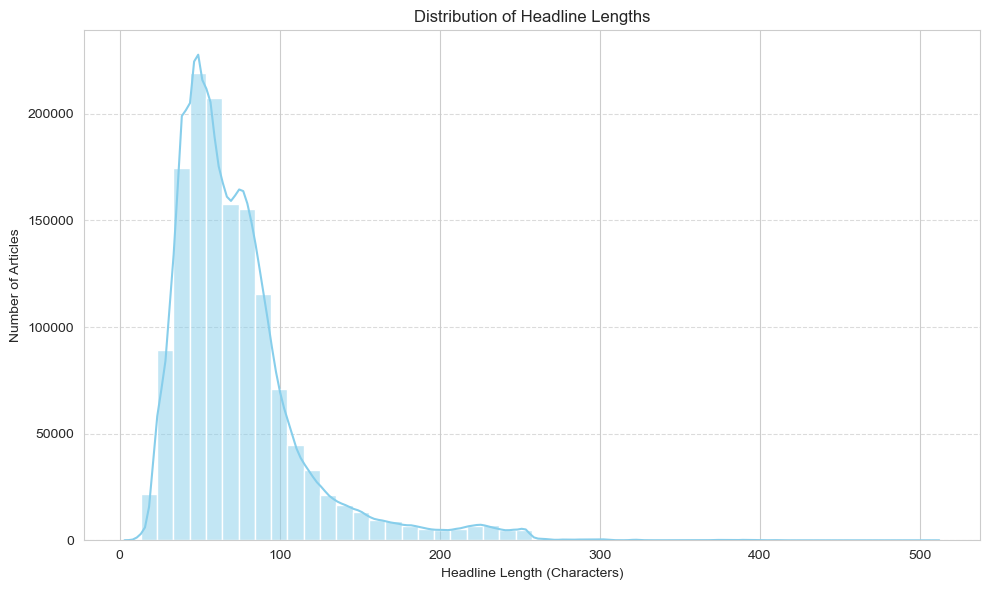


Longest Headline (Length: 512):
'JinkoSolar Tiger Pro Series Receives World's First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in the world, today announced that its innovative Tiger Pro Series of high-efficiency modules received the world's first IEC 61701 Ed. 3 (FDIS) certification for salt mist corrosion test issued by TÜV Nord AG, an independent provider of technical ser'

Shortest Headline (Length: 3):
'SPY'


In [10]:
print("\n--- Descriptive Statistics: Headline Lengths ---")

# Get descriptive statistics for headline length
print("Basic statistics for headline length:")
print(news_df['headline_length'].describe())

# Visualize the distribution of headline lengths
plt.figure(figsize=(10, 6))
sns.histplot(news_df['headline_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (Characters)')
plt.ylabel('Number of Articles')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Find the longest and shortest headlines for inspection
longest_headline = news_df.loc[news_df['headline_length'].idxmax()]
shortest_headline = news_df.loc[news_df['headline_length'].idxmin()]

print(f"\nLongest Headline (Length: {longest_headline['headline_length']}):")
print(f"'{longest_headline['headline']}'")

print(f"\nShortest Headline (Length: {shortest_headline['headline_length']}):")
print(f"'{shortest_headline['headline']}'")


--- Descriptive Statistics: Publication Date Trends ---

Articles Per Year:
publication_year
2011.0      760
2012.0     1187
2013.0     1240
2014.0     1189
2015.0     3695
2016.0     4223
2017.0     3581
2018.0     5395
2019.0     6325
2020.0    28392
Name: count, dtype: int64


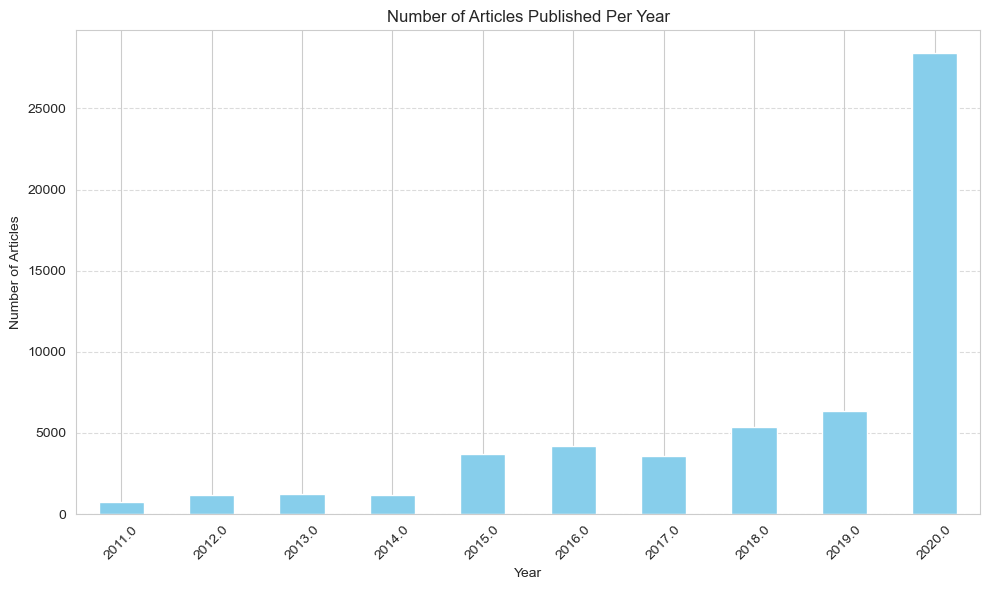


Articles Per Month:
publication_month
January       3068
February      4091
March         6391
April         6468
May          11363
June          7968
July          2131
August        2858
September     2417
October       3079
November      3210
December      2943
Name: count, dtype: int64


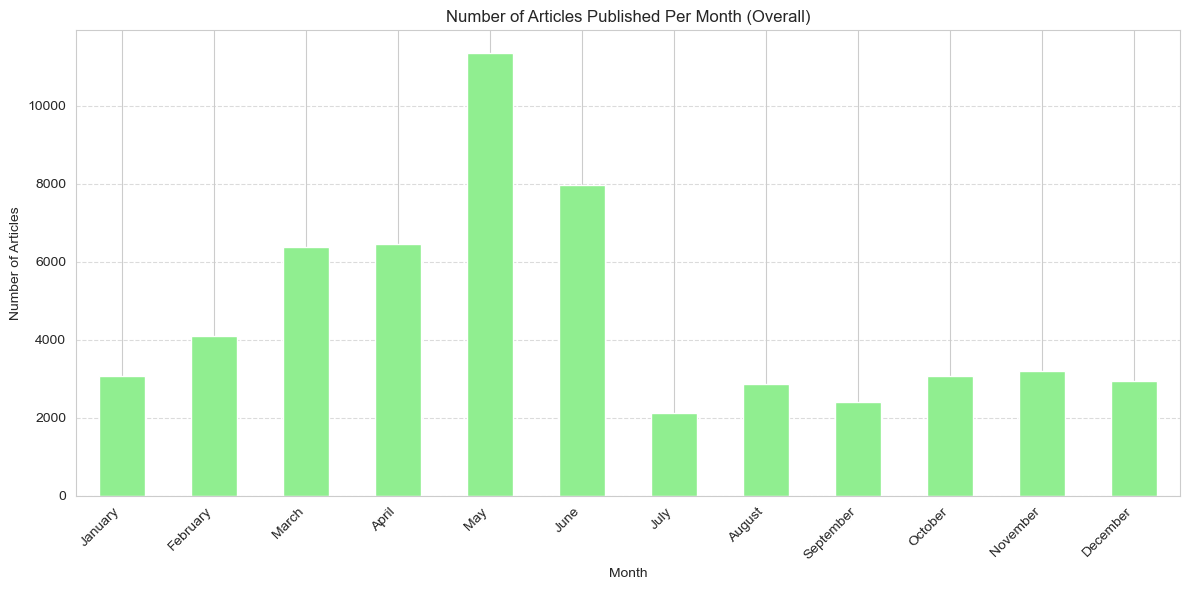


Articles Per Day of the Week:
publication_day_of_week
Monday       10325
Tuesday      11011
Wednesday    11885
Thursday     12696
Friday        9368
Saturday       266
Sunday         436
Name: count, dtype: int64


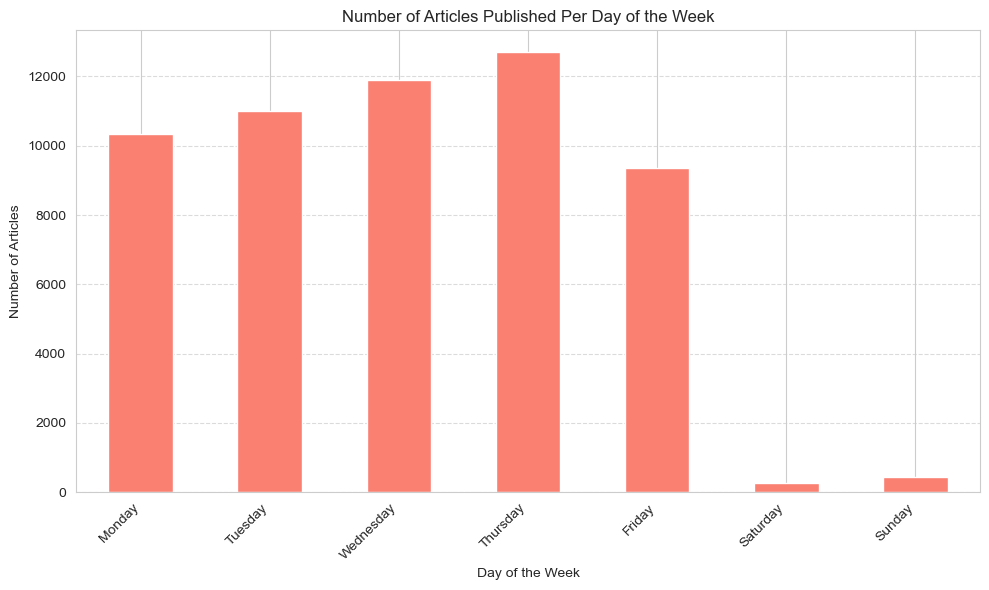


Articles Per Hour of the Day (America/New_York Time):
publication_hour
0.0       35
1.0       14
2.0       57
3.0      124
4.0     1960
5.0     1678
6.0     2831
7.0     5287
8.0     5929
9.0     5813
10.0    8967
11.0    4762
12.0    5220
13.0    2245
14.0    2062
15.0    1387
16.0    5000
17.0    1862
18.0     308
19.0     162
20.0     133
21.0      63
22.0      36
23.0      52
Name: count, dtype: int64


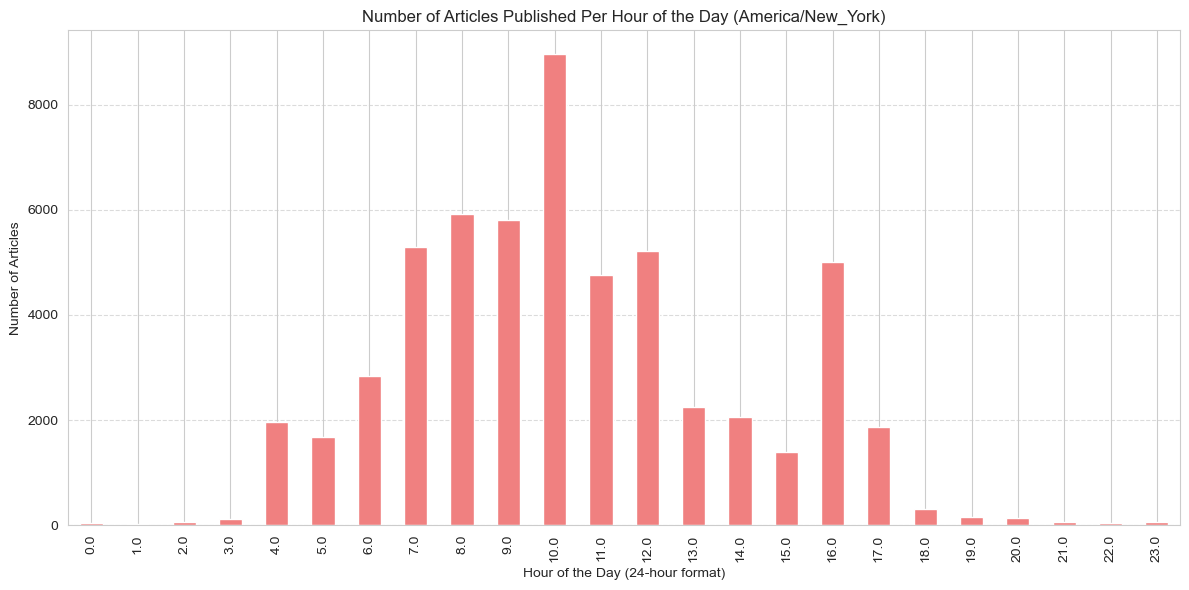

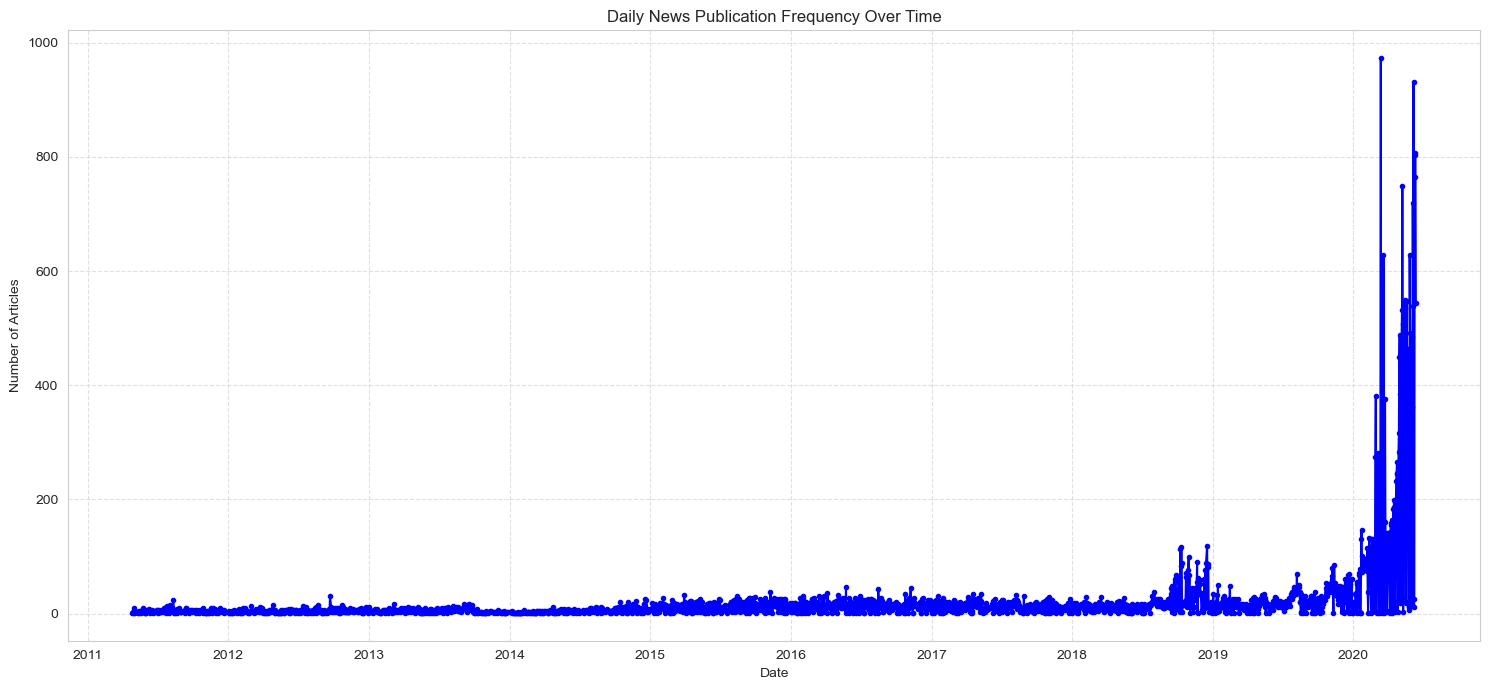

In [11]:
print("\n--- Descriptive Statistics: Publication Date Trends ---")

# Extract temporal features from the 'date' column
news_df['publication_year'] = news_df['date'].dt.year
news_df['publication_month'] = news_df['date'].dt.month_name()
news_df['publication_day_of_week'] = news_df['date'].dt.day_name()
news_df['publication_hour'] = news_df['date'].dt.hour
news_df['publication_date_only'] = news_df['date'].dt.date # For daily frequency

# 1. Articles per year
articles_per_year = news_df['publication_year'].value_counts().sort_index()
print("\nArticles Per Year:")
print(articles_per_year)

plt.figure(figsize=(10, 6))
articles_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Articles per month (across all years)
# Define order for months for consistent plotting
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
articles_per_month = news_df['publication_month'].value_counts().reindex(month_order)
print("\nArticles Per Month:")
print(articles_per_month)

plt.figure(figsize=(12, 6))
articles_per_month.plot(kind='bar', color='lightgreen')
plt.title('Number of Articles Published Per Month (Overall)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Articles per day of the week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
articles_per_day_of_week = news_df['publication_day_of_week'].value_counts().reindex(day_order)
print("\nArticles Per Day of the Week:")
print(articles_per_day_of_week)

plt.figure(figsize=(10, 6))
articles_per_day_of_week.plot(kind='bar', color='salmon')
plt.title('Number of Articles Published Per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Articles per hour of the day (in UTC-4)
articles_per_hour = news_df['publication_hour'].value_counts().sort_index()
print("\nArticles Per Hour of the Day (America/New_York Time):")
print(articles_per_hour)

plt.figure(figsize=(12, 6))
articles_per_hour.plot(kind='bar', color='lightcoral')
plt.title('Number of Articles Published Per Hour of the Day (America/New_York)')
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Number of Articles')
plt.xticks(range(0, 24)) # Ensure all hours are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Daily news frequency over time (time series plot)
# Group by just the date (no time) for a daily count
articles_daily_frequency = news_df['publication_date_only'].value_counts().sort_index()

plt.figure(figsize=(15, 7))
articles_daily_frequency.plot(kind='line', marker='o', linestyle='-', color='blue', markersize=3)
plt.title('Daily News Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [12]:
import nltk

nltk.download('punkt', download_dir='C:/Users/Shib/AppData/Roaming/nltk_data')
nltk.download('stopwords', download_dir='C:/Users/Shib/AppData/Roaming/nltk_data')

[nltk_data] Downloading package punkt to
[nltk_data]     C:/Users/Shib/AppData/Roaming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:/Users/Shib/AppData/Roaming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import nltk
nltk.data.path.append('C:/Users/Shib/AppData/Roaming/nltk_data')

In [14]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'stock', 'market', 'company', 'report', 'analyst', 'news', 'price', 'target',
    'shares', 'firm', 'group', 'investment', 'financial', 'new', 'update',
    'buy', 'sell', 'hold', 'top', 'bottom', 'high', 'low', 'rating', 'inc',
    'co', 'corp', 'ltd', 'plc', 'llc', 'etf', 'nasdaq', 'nyse', 'bloomberg',
    'dow', 's&p', '500', 'index', 'outlook', 'result', 'gain', 'loss',
    'percent', 'quarter', 'year', 'profit', 'revenue', 'guidance', 'growth',
    'earnings', 'fiscal', 'board', 'ceo', 'cfo', 'manager', 'executive',
    'business', 'economy', 'economic', 'sector', 'industry', 'marketplace',
    'performance', 'trend', 'future', 'past', 'today', 'yesterday', 'tomorrow',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'week', 'month',
    'day', 'hour', 'minute', 'second', 'time', 'date', 'announces', 'said',
    'reports', 'issues', 'releases', 'reveals', 'shows', 'indicates', 'states',
    'adds', 'declares', 'revealed', 'announced', 'according', 'based', 'on',
    'in', 'at', 'for', 'by', 'of', 'the', 'a', 'an', 'and', 'or', 'but', 'if',
    'while', 'as', 'because', 'so', 'such', 'than', 'then', 'too', 'very',
    'about', 'above', 'below', 'between', 'into', 'onto', 'through', 'during',
    'before', 'after', 'from', 'under', 'again', 'further', 'once',
    'out', 'over', 'per', 'to', 'up', 'upon', 'with', 'via', 'etc', 'etcetera', 'ie', 'eg'
}
stop_words.update(custom_stopwords)

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Clean headlines
if 'headline' in news_df.columns:
    news_df['cleaned_headline'] = news_df['headline'].astype(str).apply(clean_text)
    news_df['cleaned_headline_tokens'] = news_df['cleaned_headline'].apply(word_tokenize)
else:
    print("🛑 'headline' column not found in news_df")


In [15]:
# --- 4. Text Analysis (Topic Modeling - Initial Exploration) ---
from matplotlib.pyplot import text

# Ensure news_df is defined (load from CSV if not already present)
try:
    news_df
except NameError:
    import pandas as pd
    news_df = pd.read_csv(r"C:\Users\Shib\Documents\Financial-News-Sentiment-Project\data\raw_analyst_ratings.csv\raw_analyst_ratings.csv")  # Change filename as needed


print("\n--- 4. Text Analysis (Topic Modeling - Initial Exploration) ---")

# Ensure 'headline' column exists for text analysis and DataFrame is not empty
if 'headline' in news_df.columns and not news_df.empty:
    # Define stopwords (English, plus common financial news terms that might not be useful)
    # These custom stopwords help focus on more specific financial topics.
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {
        'stock', 'market', 'company', 'report', 'analyst', 'news', 'price', 'target',
        'shares', 'firm', 'group', 'investment', 'financial', 'new', 'update',
        'outlook', 'co', 'inc', 'corp', 'llc', 'plc', 's', 're', 've', 'd', 'll', 'm', 't',
        'said', 'would', 'could', 'may', 'also', 'one', 'two', 'three', 'four', 'five',
        'six', 'seven', 'eight', 'nine', 'ten', 'billion', 'million', 'thousand', 'us',
        'year', 'week', 'month', 'day', 'time', 'first', 'last', 'next', 'back', 'make',
        'get', 'go', 'see', 'take', 'come', 'look', 'want', 'know', 'think', 'say', 'give',
        'find', 'tell', 'work', 'call', 'need', 'feel', 'become', 'leave', 'put', 'mean',
        'keep', 'let', 'begin', 'seem', 'help', 'talk', 'start', 'run', 'show', 'hear',
        'play', 'move', 'like', 'use', 'high', 'low', 'up', 'down', 'out', 'in', 'on', 'at',
        'by', 'for', 'with', 'about', 'from', 'into', 'over', 'under', 'through', 'between',
        'before', 'after', 'above', 'below', 'to', 'of', 'and', 'the', 'a', 'an', 'is', 'are',
        'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will',
        'would', 'can', 'could', 'should', 'might', 'must', 'this', 'that', 'these', 'those',
        'here', 'there', 'when', 'where', 'why', 'how', 'what', 'who', 'whom', 'whose', 'which',
        'if', 'then', 'than', 'as', 'at', 'by', 'for', 'from', 'in', 'into', 'of', 'off', 'on',
        'out', 'over', 'per', 'to', 'up', 'upon', 'with', 'via', 'etc', 'etcetera', 'ie', 'eg'
    }
    stop_words.update(custom_stopwords)

    # Function to preprocess text for tokenization and cleaning
    def preprocess_text(text):
        # Convert to string to handle potential non-string types (e.g., NaN)
        text = str(text)
        # Convert to lowercase
        text = text.lower()
        # Remove URLs (if any)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove punctuation and numbers, keeping only letters and spaces
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize the text into words
        tokens = word_tokenize(text)
        # Remove stopwords and single-character tokens (e.g., 'a', 'i')
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
        return tokens

    from nltk.tokenize import word_tokenize

# Assuming 'cleaned_headline' column contains strings
news_df['cleaned_headline_tokens'] = news_df['cleaned_headline'].apply(word_tokenize)

# Apply the preprocessing function to the 'headline' column
tokens = word_tokenize(text)

    # Combine all tokens from all headlines into a single list for frequency analysis
all_words = [word for tokens_list in news_df['cleaned_headline_tokens'] for word in tokens_list]

if all_words: # Proceed only if there are words after cleaning
    # Identify and print the 20 most common unigrams (single words)
    common_unigrams = Counter(all_words).most_common(20)
    print("\nMost Common Unigrams (Keywords) in Headlines:")
    for word, count in common_unigrams:
        print(f"- {word}: {count}")

    # Visualize the top 20 most common unigrams
    words, counts = zip(*common_unigrams)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=list(counts), y=list(words), palette='coolwarm')
    plt.title('Top 20 Most Common Unigrams in News Headlines')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

    # --- Identify common phrases (bigrams and trigrams) ---
    from nltk.util import ngrams

    # Generate bigrams (sequences of 2 words) from cleaned headlines
    all_bigrams = []
    for tokens_list in news_df['cleaned_headline_tokens']:
        all_bigrams.extend(list(ngrams(tokens_list, 2)))

    if all_bigrams: # Proceed only if bigrams were found
        # Identify and print the 15 most common bigrams
        common_bigrams = Counter(all_bigrams).most_common(15)
        print("\nMost Common Bigrams (Phrases) in Headlines:")
        for bigram, count in common_bigrams:
            print(f"- {' '.join(bigram)}: {count}")

        # Visualize the top 15 most common bigrams
        bigram_phrases = [' '.join(bigram) for bigram, count in common_bigrams]
        bigram_counts = [count for bigram, count in common_bigrams]
        plt.figure(figsize=(12, 7))
        sns.barplot(x=bigram_counts, y=bigram_phrases, palette='magma')
        plt.title('Top 15 Most Common Bigrams in News Headlines')
        plt.xlabel('Frequency')
        plt.ylabel('Phrase')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo meaningful bigrams found after cleaning. Headlines might be too short or too sparse.")

    # Generate trigrams (sequences of 3 words) from cleaned headlines
    all_trigrams = []
    for tokens_list in news_df['cleaned_headline_tokens']:
        all_trigrams.extend(list(ngrams(tokens_list, 3)))

    if all_trigrams: # Proceed only if trigrams were found
        # Identify and print the 10 most common trigrams
        common_trigrams = Counter(all_trigrams).most_common(10)
        print("\nMost Common Trigrams (Phrases) in Headlines:")
        for trigram, count in common_trigrams:
            print(f"- {' '.join(trigram)}: {count}")

        # Visualize the top 10 most common trigrams
        trigram_phrases = [' '.join(trigram) for trigram, count in common_trigrams]
        trigram_counts = [count for trigram, count in common_trigrams]
        plt.figure(figsize=(12, 7))
        sns.barplot(x=trigram_counts, y=trigram_phrases, palette='cividis')
        plt.title('Top 10 Most Common Trigrams in News Headlines')
        plt.xlabel('Frequency')
        plt.ylabel('Phrase')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo meaningful trigrams found after cleaning. Headlines might be too short or too sparse.")

    print("\n--- Interpretation of Text Analysis ---")
    print("The common unigrams, bigrams, and trigrams provide insights into the recurring themes and entities in the financial news headlines.")
    print("For instance, you might see terms like 'buy rating', 'sell rating', 'downgrade', 'upgrade' directly related to analyst actions.")
    print("Company names (e.g., 'apple', 'tesla') or industry-specific terms (e.g., 'pharma sector', 'oil prices') will also frequently appear.")
    print("This initial text analysis helps in understanding the dominant topics without complex topic modeling algorithms.")
    print("For more advanced topic extraction, techniques like Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) could be applied, but this initial step is crucial for gaining immediate insights.")
else:
    print("\nNo words found in headlines after cleaning and preprocessing. Please check the content of your 'headline' column or adjust the preprocessing steps (e.g., custom stopwords).")


print("\n--- EDA (Exploratory Data Analysis) Complete ---")


--- 4. Text Analysis (Topic Modeling - Initial Exploration) ---


TypeError: expected string or bytes-like object